In [1]:
#Import necessary lib

import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt

In [2]:
#Use dataset car.csv (vehicle)
data = pd.read_csv("car.csv")
#Class in dataset
Y = data['Class']
#Distribution by class in out dataset
one_hot = pd.get_dummies(data['Class'], prefix = 'Class')
#Our dataset without column "Class"
X = data.drop(columns = ['Class'])
#Minimax normalization
X = ((X - np.min(X)) / (np.max(X) - np.min(X))).to_numpy()
#Our data one_hot to array one_hot
One_Hot_encoding = one_hot.to_numpy()
#Dictionary for saving class numbers
dictionary = {}
#Complete the dictionary unique key (class)
for j in range((Y.unique()).size):
    dictionary[Y.unique()[j]] = j
#See unique class in our dataset
Y.unique()

D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


array(['van', 'saab', 'bus', 'opel'], dtype=object)

In [3]:
#Dictionary for saving class numbers (with 0 and 1)
dic = {}
#Complete the dictionary

for i in range(One_Hot_encoding.shape[0]):
    k = One_Hot_encoding[i]
    key = np.array2string(k, precision=2, separator='')
    dic[key] = dictionary[Y[i]]

In [4]:
dictionary

{'van': 0, 'saab': 1, 'bus': 2, 'opel': 3}

In [5]:
dic

{'[0001]': 0, '[0010]': 1, '[1000]': 2, '[0100]': 3}

In [6]:
#Distance function
def dist_Funcs(x, y, f):
    
    if f == 'Manhattan':
        return np.sum(np.abs(x - y))
    elif f == 'Euclidian':
        return np.power(np.sum(np.power(np.abs(x - y),2)),1/2)
    else:
        return np.max(np.abs(x - y),axis=0)

In [7]:
#Core function
def core_Funcs (x, core):
    
    if core == 'uniform':
        return 1/2
    elif core == 'triangle':
        return 1 - np.abs(x)
    elif core == 'epanechnikov':
        return 3/4*(1 - np.abs(x))
    else:
        return 15/16*np.power((1 - np.power(x,2)),2)

In [8]:
def distance (u,x,function):
    distances = []
    
    for i in range (len(x)):
        a = dist_Funcs(u,x[i],function)
        
        if a == 0:
            continue
        distances.append(a)
    
    M = {k: v for k, v in enumerate(distances)}
    M = dict(sorted(M.items(), key = lambda item:item[1]))
    return M

In [9]:
def Distances(C,fun):
    Dist = []
    for i in range(len(C)):
        u = X[i]
        a = distance(u,C,fun)
        Dist.append(a)
    
    return Dist

In [10]:
#Size Window (RD)
def Max_distances(C,fun):
    RD = 0
    for i in range(len(C)):
        u = X[i]
        a = distance(u,C,fun)
        RD = max(RD,max(a.values()))
    
    return RD

In [11]:
#kNN algorithm
def KNN(ker_function, K, h, Y):
    
    Predict = np.array([])
    
    for i in range (len(Dist)):
        di = np.array(list(Dist[i].values()))
        po = np.array(list(Dist[i].keys()))
        Num = np.zeros((Y.shape[1],))
        Den = np.zeros((Y.shape[1],))
        
        for j in range (K):
            y = Y.iloc[po[j]]
            
            if h == 0:
                di = di/rd
            else:
                di = di/di[K+1]
            x = core_Funcs (di[j], ker_function)
            Num = Num + (x * y)
            Den = Den + x
        Predict = np.append(Predict, Num/Den)
    A = Predict.reshape(len(Dist),Y.shape[1])
    Max = (A - np.max(A, axis=1).reshape(A.shape[0],1))
    Max = (Max == 0)*1
    
    for i in range(A.shape[0]):
        
        if (sum(Max[i])>1):
            index = np.where(Max[i] == 1)
            Max[i] = np.zeros((1,A.shape[1]))
            Max[i][index[0][0]]= 1
        elif (sum(Max[i]) == 0):
            Max[i][random.randint(0, 3)] = 1
    return Max

In [12]:
#F-measure
def F_measure(Y,A,category):
    Pred_matrix = np.zeros((Y.shape[1],Y.shape[1]))
    F = np.zeros((1,Pred_matrix.shape[0]))
    
    for i in range (len(A)):
        Y_orig = np.array2string(Y[i], separator='')
        Y_pre = np.array2string(A[i], separator='')
        Pred_matrix[category[Y_pre]-1][category[Y_orig]-1] +=1
        
    for i in range(Pred_matrix.shape[0]):
        TP = Pred_matrix[i][i]
        FP = np.sum(Pred_matrix[i], axis = 0) - TP
        FN = np.sum([Pred_matrix[:,i]], axis = 1) - TP
        Recall = TP/(TP+FN)
        Precision = TP/(TP+FP)
        F_1 = 2*(Recall*Precision)/(Recall+Precision)
        F[0][i] = F_1
        
    return np.average(F)

In [13]:
Distance_Function = []
Kernel_Function = []
Window = []
K_neighbor = []
F1_measure = []

for dis in (['Manhattan','Euclidean','Chebyshev']):
    Dist = Distances(X,dis)
    rd = Max_distances(X,dis)
    
    for ker in (['uniform','triangle','epanechnikov','quartic']):
        
        for h in range(2):
            
            for k in (range(1,int(np.sqrt(X.shape[0])))):
                A = KNN(ker, k, h, one_hot)
                F1 = F_measure(One_Hot_encoding,A,dic)
                
                Distance_Function.append(dis)
                Kernel_Function.append(ker)
                Window.append(h)
                K_neighbor.append(k)
                F1_measure.append(F1)

In [14]:
i = max(F1_measure)
max_index = F1_measure.index(i)
print("Best result: "+ str(F1_measure[max_index]))
print("Best choice is:\nDistance Function:"+ Distance_Function[max_index])
print("Kernel Function: "+ Kernel_Function[max_index])
print("Type of window: "+ str(Window[max_index]))
print("Num of Neighbors: "+ str(K_neighbor[max_index]))

Best result: 0.5917771570870912
Best choice is:
Distance Function:Manhattan
Kernel Function: triangle
Type of window: 1
Num of Neighbors: 28


In [16]:
K_N= []
F_m= []

Dist = Distances(X,Distance_Function[max_index])
rd = Max_distances(X,Distance_Function[max_index])

for k in (range(1,int(np.sqrt(X.shape[0])))):
    A = KNN(Kernel_Function[max_index], k, Window[max_index], one_hot)
    F1 = F_measure(One_Hot_encoding,A,dic)
    K_N.append(k)
    F_m.append(F1)
    
plt.plot(K_N,F_m)

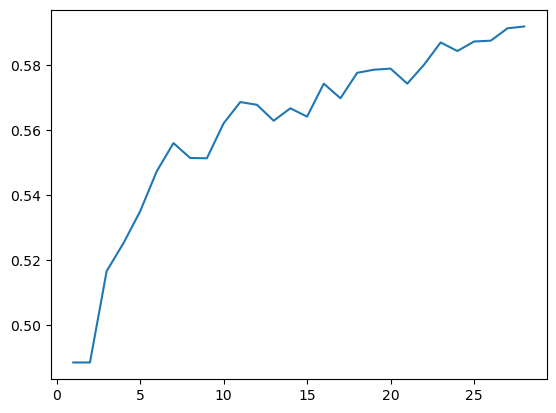

In [17]:
plt.show()